In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [27]:
# HIPERPARÂMETROS:
start_date = '2014-08-21'
W = 300  # Lembrando que o tamanho do treinamento será W - w
w = 7

In [28]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD'
]

In [29]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [30]:
def fracdiff_weights(d, size):
    we = [1.0]
    for k in range(1, size):
        we.append(-we[-1]/k*(d - k + 1))
    return np.array(we[::-1])
#return np.array(we[::-1])

In [31]:
def fracDiff_FFD(series, d, thres=0.01):
    # 1) Compute weights for the longest series
    w = fracdiff_weights(d, 30)  # Passa o tamanho como inteiro
    width = len(w) - 1
    
    # 2) Apply weights to values
    df = {}
    for name in series.columns:
        # Forward fill missing values
        seriesF = series[[name]].ffill().dropna()
        df_ = pd.Series(index=seriesF.index, dtype=float)  # Predefine empty series
        
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(seriesF.loc[loc1, name]): 
                continue  # Exclude NAs
            window = seriesF.loc[loc0:loc1][name].values
            df_[loc1] = np.dot(w, window)
        
        df[name] = df_.copy(deep=True)
    
    df = pd.concat(df, axis=1)
    return df


In [32]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Crypto_Price': np.log(df['Open'].squeeze()),
        'Crypto_Return_Today': df['Return']
    }).dropna()


    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [33]:
data[crypto]

,Crypto_Price,Crypto_Return_Today
Date,,
2017-11-09,5.732192,0.038888
2017-11-10,5.770416,-0.069126
2017-11-11,5.699058,0.052501
2017-11-12,5.751588,-0.021787
2017-11-13,5.726929,0.031076
...,...,...
2024-11-11,8.068295,0.055800
2024-11-12,8.124196,-0.038938
2024-11-13,8.084730,-0.016140


In [34]:
aux = yf.download('BTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = np.log(aux['Open'])
aux = pd.DataFrame({'Aux_Price': aux['Return']})

for crypto in cryptos:
    if crypto != 'BTC-USD':
        data[crypto] = pd.merge(aux, data[crypto],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%%**********************]  1 of 1 completed


In [35]:
data['ETH-USD']

,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2017-11-09,8.915544,5.732192,0.038888
2017-11-10,8.878181,5.770416,-0.069126
2017-11-11,8.797641,5.699058,0.052501
2017-11-12,8.747582,5.751588,-0.021787
2017-11-13,8.689170,5.726929,0.031076
...,...,...,...
2024-11-11,11.295657,8.068295,0.055800
2024-11-12,11.393078,8.124196,-0.038938
2024-11-13,11.384296,8.084730,-0.016140


In [36]:
aux = yf.download('ETH-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = np.log(aux['Open'])
aux = pd.DataFrame({'Aux_Price': aux['Return']})

data['BTC-USD'] = pd.merge(aux, data['BTC-USD'],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%%**********************]  1 of 1 completed


In [37]:
from statsmodels.tsa.stattools import adfuller
def fracdiff(series, weights):
    diff_series = []
    for i in range(window_size, len(series)):
        window = series[i - window_size:i]
        diff_value = np.dot(weights, window)
        diff_series.append(diff_value)
    return pd.Series(diff_series, index=series.index[window_size:])


def find_optimal_d(series, window_size=10, threshold=0.01, d_step=0.01, max_d=1.0):
    d = 0.2  # Inicie com d = 0.2
    while d <= max_d:
        diff_series = fracDiff_FFD(series, d).dropna()
        # Executa o teste ADF
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]

        # Verifica se o p_value é menor que o threshold
        if p_value < threshold:
            return d, p_value  # Retorna o d encontrado e o p_value correspondente

        # Aumenta d pelo passo definido
        d += d_step

    # Caso não encontre um d adequado
    return 1, None

In [38]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [39]:
print(len(data_complete['ETH-USD']))
data['ETH-USD']

2564


,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2017-11-09,8.915544,5.732192,0.038888
2017-11-10,8.878181,5.770416,-0.069126
2017-11-11,8.797641,5.699058,0.052501
2017-11-12,8.747582,5.751588,-0.021787
2017-11-13,8.689170,5.726929,0.031076
...,...,...,...
2024-11-11,11.295657,8.068295,0.055800
2024-11-12,11.393078,8.124196,-0.038938
2024-11-13,11.384296,8.084730,-0.016140


In [41]:
optimal_d = {}
for crypto in cryptos:
    close_prices = pd.DataFrame(data[crypto]['Crypto_Price'])
    optimal_d[crypto] = find_optimal_d(close_prices, window_size=30, threshold=0.01, d_step=0.01, max_d=1.0)
    auxiliar = fracDiff_FFD(data[crypto]['Crypto_Price'], optimal_d[crypto])
    data[crypto]['diff_Crypto_Price'] = auxiliar

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [ ]:
for crypto in cryptos:
    if crypto == 'BTC-USD':
        auxiliar = fracDiff_FFD(data[crypto]['Aux_Price'], optimal_d['ETH-USD'])
        data[crypto]['diff_Aux_Price'] = auxiliar
    else:
        auxiliar = fracDiff_FFD(data[crypto]['Aux_Price'], optimal_d['BTC-USD'])
        data[crypto]['diff_Aux_Price'] = auxiliar
       

In [19]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [226]:
# Aqui eu perco W+1 dias do meu dataset
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [227]:
print(len(data['ETH-USD']))
data['ETH-USD'][0]

2263


,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-20,10.636446,7.819977,-0.008170
2024-01-21,10.637572,7.811892,-0.006453
2024-01-22,10.634741,7.805877,-0.060516
2024-01-23,10.584530,7.745415,-0.030877
2024-01-24,10.593570,7.715012,-0.003659
...,...,...,...
2024-11-11,11.295657,8.068295,0.055800
2024-11-12,11.393078,8.124196,-0.038938
2024-11-13,11.384296,8.084730,-0.016140


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [243]:
data[crypto][day]['Crypto_Price']

Date
2024-01-20    10.636446
2024-01-21    10.637572
2024-01-22    10.634741
2024-01-23    10.584530
2024-01-24    10.593570
                ...    
2024-11-11    11.295657
2024-11-12    11.393078
2024-11-13    11.384296
2024-11-14    11.413932
2024-11-15    11.376925
Name: Crypto_Price, Length: 301, dtype: float64

In [ ]:
optimal_d = {}
p_value = {}
for crypto in cryptos:
    optimal_d[crypto] = {}
    p_value[crypto] = {}


for crypto in cryptos:
  for day in range(len(data[crypto])):
    close_prices = pd.DataFrame(data[crypto][day]['Crypto_Price'])
    optimal_d[crypto][day], p_value[crypto][day] = find_optimal_d(close_prices, window_size=30, threshold=0.0001, d_step=0.01, max_d=1.0)
    print(crypto, optimal_d[crypto][day], p_value[crypto][day])

BTC-USD 0.38000000000000017 6.82436372032257e-05
BTC-USD 0.4100000000000002 6.601537757189135e-05
BTC-USD 0.3900000000000002 8.74515784603811e-05
BTC-USD 0.4000000000000002 9.75513895786011e-05
BTC-USD 0.3300000000000001 9.056950973305091e-05
BTC-USD 0.3000000000000001 7.985156217053054e-05
BTC-USD 0.3000000000000001 8.700487098863761e-05
BTC-USD 0.2900000000000001 9.827281773458921e-05
BTC-USD 0.2900000000000001 8.962543168177784e-05
BTC-USD 0.26000000000000006 9.062255978249763e-05
BTC-USD 0.23000000000000004 9.911838754405287e-05
BTC-USD 0.23000000000000004 8.147305065411251e-05
BTC-USD 0.21000000000000002 8.263149765878932e-05
BTC-USD 0.21000000000000002 9.34402277257556e-05
BTC-USD 0.24000000000000005 7.767938001349364e-05
BTC-USD 0.2800000000000001 9.061535357902776e-05
BTC-USD 0.3000000000000001 8.68466675782489e-05
BTC-USD 0.2900000000000001 8.603718954778281e-05
BTC-USD 0.2800000000000001 9.39850770243309e-05
BTC-USD 0.3000000000000001 8.457176228977305e-05
BTC-USD 0.310000000

In [ ]:
import winsound

# Frequência em Hertz e duração em milissegundos
frequencia = 1000  # 1 kHz
duracao = 500      # 500 ms

# Emite o som
winsound.Beep(frequencia, duracao)

In [66]:
df = pd.DataFrame(optimal_d['BTC-USD'].values(), columns=['Value'])
df

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [31]:
for crypto in cryptos:
  pd.DataFrame(optimal_d[crypto].values(), columns=['Value']).to_csv(f"{crypto}_d_value.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [126]:
optimal_d = {}

for crypto in cryptos:
  optimal_d[crypto] = pd.read_csv(f"{crypto}_optimal_d.csv", index_col = 0)

In [127]:
for crypto in cryptos:
  optimal_d[crypto] = optimal_d[crypto].to_numpy().flatten()

In [128]:
data['BTC-USD'][0]

,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-20,7.819977,10.636446,0.000984
2024-01-21,7.811892,10.637572,-0.003021
2024-01-22,7.805877,10.634741,-0.050498
2024-01-23,7.745415,10.584530,0.008236
2024-01-24,7.715012,10.593570,0.004990
...,...,...,...
2024-11-11,8.068295,11.295657,0.097375
2024-11-12,8.124196,11.393078,-0.008488
2024-11-13,8.084730,11.384296,0.029739


In [130]:
window_size = 10

for crypto in cryptos:
  if crypto != 'BTC-USD':
    for day in range(len(data[crypto])):
      if day < len(data['BTC-USD']):
        daily_data = data[crypto][day].copy()
        d = optimal_d['BTC-USD'][day] ## LEMBRAR DE RECORRIGIR
        if d == 0.9:
          d = 1 
        weights = fracdiff_weights(d, window_size)
        daily_data['diff_Aux_Price'] = fracdiff(daily_data['Aux_Price'], weights).shift(-1)

        columns = list(daily_data.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data[columns]


        daily_data2 = data[crypto][day].copy()
        d = optimal_d[crypto][day]
        if d == 0.9:
          d = 1
        weights = fracdiff_weights(d, window_size)
        daily_data2['diff_Crypto_Price'] = fracdiff(daily_data2['Crypto_Price'], weights).shift(-1)

        columns = list(daily_data2.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data2[columns]

  if crypto == 'BTC-USD':
      for day in range(len(data[crypto])):

        daily_data = data[crypto][day].copy()
        
        d = optimal_d['ETH-USD'][day]

        if d == 0.9:
          d = 1
        weights = fracdiff_weights(d, window_size)
        daily_data['diff_Aux_Price'] = fracdiff(daily_data['Aux_Price'], weights).shift(-1)

        columns = list(daily_data.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data[columns]


        daily_data2 = data[crypto][day].copy()
        d = optimal_d[crypto][day]
        if d == 0.9:
          d = 1
        weights = fracdiff_weights(d, window_size)
        daily_data2['diff_Crypto_Price'] = fracdiff(daily_data2['Crypto_Price'], weights).shift(-1)

        columns = list(daily_data2.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data2[columns]

ADF t-statistic para série fracionariamente diferenciada: -3.493743380808816
ADF p-value para série fracionariamente diferenciada: 0.008149238718481937
d_value: 0.7000000000000003


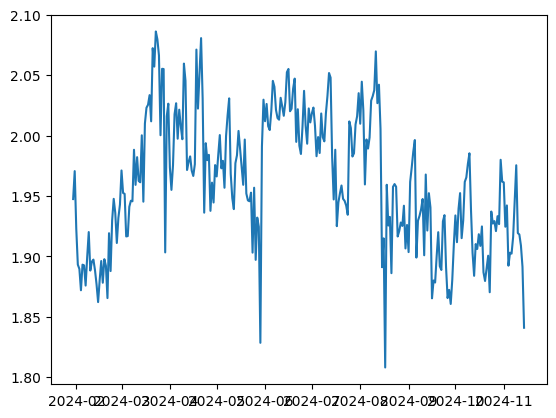

In [131]:
#adf_result = adfuller(close_prices_frac_diff.dropna().loc['2019-06-30':])  # Remova valores NA, se houver
adf_result = adfuller(data[crypto][0]['diff_Crypto_Price'].dropna())
# Obtenha o t-statistic e o p-value
t_statistic = adf_result[0]
p_value = adf_result[1]


print("ADF t-statistic para série fracionariamente diferenciada:", t_statistic)
print("ADF p-value para série fracionariamente diferenciada:", p_value)
print("d_value:", optimal_d[crypto][1500])

#plt.plot(pd.DataFrame(close_prices_frac_diff.loc['2019-06-30':]))
plt.plot(pd.DataFrame(data[crypto][0]['diff_Crypto_Price']))

In [132]:
data['ETH-USD'][0].dropna()

,Aux_Price,Crypto_Price,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
Date,,,,,
2024-01-30,10.675913,7.748217,2.524593,1.947500,0.011608
2024-01-31,10.667705,7.759426,2.540769,1.970639,-0.026380
2024-02-01,10.658899,7.732884,2.483843,1.923027,0.009442
2024-02-02,10.670759,7.742274,2.487417,1.893213,0.001879
2024-02-03,10.673248,7.744128,2.487117,1.889667,-0.005188
...,...,...,...,...,...
2024-11-10,11.248641,8.049021,2.639245,1.919357,0.019172
2024-11-11,11.295657,8.068295,2.627552,1.918115,0.055800
2024-11-12,11.393078,8.124196,2.622829,1.908965,-0.038938


In [85]:
for crypto in cryptos:
  for day in range(len(data[crypto])):
    data[crypto][day] = data[crypto][day].dropna()
    data[crypto][day] = data[crypto][day].drop(columns = ['Aux_Price', 'Crypto_Price'])

In [86]:
data['BTC-USD'][0]

,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-30,1.919537,2.549848,-0.008060
2024-01-31,1.920846,2.527060,-0.008503
2024-02-01,1.887311,2.517169,0.011817
2024-02-02,1.905297,2.530745,0.002509
2024-02-03,1.904450,2.527488,-0.004473
...,...,...,...
2024-11-10,2.051975,2.674508,0.047050
2024-11-11,2.036607,2.715383,0.097375
2024-11-12,2.070532,2.788430,-0.008488


In [87]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [88]:
data['ETH-USD'][0], test_target['ETH-USD'][0]['Crypto_Return_Today']

(            diff_Aux_Price  diff_Crypto_Price  Crypto_Return_Today
 Date                                                              
 2024-01-30        2.549848           1.919537             0.011608
 2024-01-31        2.527060           1.920846            -0.026380
 2024-02-01        2.517169           1.887311             0.009442
 2024-02-02        2.530745           1.905297             0.001879
 2024-02-03        2.527488           1.904450            -0.005188
 ...                    ...                ...                  ...
 2024-11-09        2.681190           2.020271             0.055267
 2024-11-10        2.674508           2.051975             0.019172
 2024-11-11        2.715383           2.036607             0.055800
 2024-11-12        2.788430           2.070532            -0.038938
 2024-11-13        2.728328           1.996101            -0.016140
 
 [289 rows x 3 columns],
 2024-11-14   -0.042739
 Name: Crypto_Return_Today, dtype: float64)

## 2.3 Bagging

In [33]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_model(a, b):
    model = Sequential([
        Input(shape=(a, b)),
        Conv1D(15, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=50, return_sequences=False),
        BatchNormalization(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(units=1)
    ])
    optimizer = RMSprop(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [93]:
# Função do modelo LSTM
def Model(df, time_step, features, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i+1, :-1])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i, -1])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)


    # Conjunto de validação - primeiros 30 elementos
    X_val = X_lstm[-20:-1]
    y_val = y_lstm[-20:-1]
    y_val = pd.DataFrame(y_val).to_numpy().reshape((len(y_val), 1))

    # Separar o X_train (todos exceto o último elemento)
    X_train = X_lstm[:-20]
    y_train = y_lstm[:-20]
    y_train = pd.DataFrame(y_train).to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test).to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # Treinar o modelo específico para a criptomoeda

    # Arquitetura 1:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=0)
    #model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[reduce_lr])

    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    # Arquitetura 2:
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 300, verbose=1, callbacks=[early_stopping])
    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)


    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [94]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [95]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando CPU


In [96]:
for crypto in cryptos:
    print(len(data[crypto]))
len(data['ETH-USD'][0])

2263
2263


289

In [97]:
test_target['ETH-USD'][2042]
#test_target['ETH-USD'][2138]

,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
2019-04-13,0.057978,0.19039,-0.000665


In [98]:
aux = data_complete['ETH-USD'].loc['2019-01-05':'2019-04-10']
num_positive = (aux['Crypto_Return_Today'] > 0).sum()
num_negative = (aux['Crypto_Return_Today'] < 0).sum()

print("\n\n--------------------------------------------------------")
print("\n\nCriptomoeda: ", 'ETH')
print("\n                              Real")
print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")



--------------------------------------------------------


Criptomoeda:  ETH

                              Real

Numero de Subidas:  48    |    50.0 %

Numero de Quedas :  48    |    50.0 %


In [99]:
cryptos = ['BTC-USD', 'ETH-USD']
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, time_step, features):
    # Criar um modelo para cada criptomoeda
    for day in range(1900, 2000):
        model = create_model(time_step, features)

        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, features, model=model)  # Chamar o modelo para previsão

        y_hat_scaled = np.repeat(y_hat_scaled, features+1, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=(['Predictions_1'], ['Predictions_2'], ['Predictions_1']))

        y_hat = scaler.inverse_transform(y_hat_scaled)[0][features]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")

# Número de samples que vamos testar o modelo
time_step = w
features = 2

# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, time_step, features)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

Epoch 1/300
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 4.6404 - val_loss: 0.6331
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7385 - val_loss: 0.6335
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 3.6084 - val_loss: 0.6086
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8490 - val_loss: 0.6361
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9089 - val_loss: 0.5896
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8655 - val_loss: 0.6390
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9469 - val_loss: 0.5856
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1379 - val_loss: 0.6379
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.6270Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3519 - val_loss: 0.5934
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3326 - val_loss: 0.6359
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5672 - val_loss: 0.6129
Epoch 6/300
9/9

42min para 100 dias


In [100]:
import winsound

# Frequência em Hertz e duração em milissegundos
frequencia = 1000  # 1 kHz
duracao = 500      # 500 ms

# Emite o som
winsound.Beep(frequencia, duracao)

In [101]:
df = data_complete['BTC-USD']
df.dropna()

,Crypto_Return_Today,exp_value
Date,,
2019-05-26,0.073921,0.014318
2019-05-27,0.015070,0.003347
2019-05-28,-0.009450,0.000233
2019-05-29,-0.006802,0.016718
2019-05-30,-0.040319,0.014756
...,...,...
2019-08-29,-0.025598,0.003492
2019-08-30,0.008720,0.000058
2019-08-31,0.003445,0.002588


In [44]:
data_visual = data_complete

In [45]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + TN + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram
    limite_90 = df['exp_value'].quantile(0.9)

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= limite_90)).sum()


    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)

    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  56    |    56.0 %

Numero de Quedas :  44    |    44.0 %

                              Predito

Numero de Subidas:  70    |    70.0 %

Numero de Quedas :  30    |    30.0 %

Mean Absolute Error MAE:  0.03542518974165161

Acc:  0.44

Sen:  0.625

Spe:  0.625

Pre:  0.5

Lower bound dos 10% maiores:  0.010434472933411598

Precisao para maiores que 0.008:  0.4


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  52    |    52.0 %

Numero de Quedas :  48    |    48.0 %

                              Predito

Numero de Subidas:  53    |    53.0 %

Numero de Quedas :  47    |    47.0 %

Mean Absolute Error MAE:  0.032463842800022874

Acc:  0.53

Sen:  0.5576923076923077

Spe:  0.5576923076923077

Pre:  0.5471698113207547

Lower bound dos 10% maiores:  0.00521995825693

In [ ]:
data_aux = {}
for crypto in cryptos:
    data_aux[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')

In [ ]:
data_aux['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2019-02-13,-0.005911,-0.000663,0.005248
2019-02-14,-0.003943,-0.000381,0.003561
2019-02-15,0.000951,-0.002385,0.003336
2019-02-16,0.004008,-0.000742,0.004749
2019-02-17,0.011079,-0.000184,0.011263
...,...,...,...
2019-10-29,0.019196,0.005857,0.013339
2019-10-30,-0.023271,0.004103,0.027373
2019-10-31,-0.000312,0.005313,0.005625


In [ ]:
data_aux['BTC-USD'][-2100:]
#data_complete['BTC-USD'][:-2100]

,Crypto_Return_Today,exp_value,ae
Date,,,
2019-02-13,-0.005911,-0.000663,0.005248
2019-02-14,-0.003943,-0.000381,0.003561
2019-02-15,0.000951,-0.002385,0.003336
2019-02-16,0.004008,-0.000742,0.004749
2019-02-17,0.011079,-0.000184,0.011263
...,...,...,...
2024-11-08,0.008431,NaN,NaN
2024-11-09,0.002904,NaN,NaN
2024-11-10,0.047050,NaN,NaN


In [ ]:
for crypto in cryptos:
    df_aux = data_complete[crypto]
    df_aux = pd.concat([df_aux[:-2100], data_aux[crypto][-2100:]])
    df_aux.index = pd.to_datetime(df_aux.index)
    data_complete[crypto] = df_aux


In [ ]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [ ]:
data_complete['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2018-07-28,0.002823,0.009356,0.006534
2018-07-29,0.001539,-0.000135,0.001674
2018-07-30,-0.005012,0.002088,0.007099
2018-07-31,-0.050226,0.014113,0.064339
2018-08-01,-0.018726,0.012572,0.031298
...,...,...,...
2019-10-29,0.019196,0.005857,0.013339
2019-10-30,-0.023271,0.004103,0.027373
2019-10-31,-0.000312,0.005313,0.005625


In [ ]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"

    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

Arquivo BTC-USD.csv salvo com sucesso!
Arquivo LTC-USD.csv salvo com sucesso!


In [102]:
data_visual = data_complete.copy()

In [103]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()

    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None

    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.75)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
results_df.to_csv("resultado_arquitetura_2.csv", index = True)
results_df

,Crypto,Num Subidas (Real),Perc Subidas (Real),Num Quedas (Real),Num Subidas (Pred),Perc Subidas (Pred),Num Quedas (Pred),MAE,Acc,Sen,Spe,Pre,Lower bound dos 10% maiores,Precisao para maiores que 0.008
0,BTC-USD,56,56.0,44,74,74.0,26,0.034932,0.52,0.732143,0.25,0.554054,0.004613,0.56
1,ETH-USD,52,52.0,48,54,54.0,46,0.032840,0.54,0.576923,0.50,0.555556,0.002440,0.64


In [57]:
Pre_media = results_df['Pre'].mean()
Acc_media = results_df['Acc'].mean()
MAE_media = results_df['MAE'].mean()
Precisao_25_media = results_df['Precisao para maiores que 0.008'].mean()
print("Pre_media ", Pre_media)
print("Acc_media ", Acc_media)
print("MAE_media ", MAE_media)
print("Precisao_25_media", Precisao_25_media)

Pre_media  0.5630160271976687
Acc_media  0.5449999999999999
MAE_media  0.034030344667775186
Precisao_25_media 0.48


## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)